# Fine-Tuning en Computer Vision

## 📚 Introduction

### 🎯 Qu'est-ce que le Fine-Tuning ?

Le fine-tuning est une technique d'apprentissage par transfert qui consiste à :

1. **Partir d'un modèle pré-entraîné** (comme MobileNetV2 entraîné sur ImageNet)
2. **Adapter ce modèle** à notre problème spécifique
3. **Réentraîner partiellement** le modèle sur nos données

### 💡 Pourquoi utiliser le Fine-Tuning ?

✅ **Moins de données nécessaires** : Utilise les connaissances déjà apprises

✅ **Entraînement plus rapide** : Pas besoin de partir de zéro

✅ **Meilleures performances** : Combine les features génériques et spécifiques

✅ **Moins de ressources** : Économise du temps de calcul

### 🌺 Notre Projet

Dans ce notebook, nous allons :
- Classifier 5 types de fleurs différentes
- Utiliser le modèle MobileNetV2 pré-entraîné
- Appliquer deux phases d'entraînement
- Visualiser nos résultats à chaque étape

---

## 🔧 Configuration et Imports

Commençons par importer toutes les bibliothèques nécessaires et configurer notre environnement.

In [2]:
# Imports principaux
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import warnings
import os
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# Configuration pour un meilleur affichage
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print(f"🚀 TensorFlow version: {tf.__version__}")
print(f"💻 GPU disponible: {'✅ Oui' if len(tf.config.list_physical_devices('GPU')) > 0 else '❌ Non'}")

🚀 TensorFlow version: 2.19.0
💻 GPU disponible: ✅ Oui


### 🖥️ Configuration GPU

Si vous avez un GPU, nous allons le configurer pour éviter les erreurs de mémoire :

In [3]:
# Configuration GPU pour éviter les erreurs OOM (Out of Memory)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Limiter la croissance de la mémoire GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("✅ Configuration GPU réussie - Croissance mémoire activée")
    except RuntimeError as e:
        print(f"⚠️ Erreur configuration GPU: {e}")
else:
    print("🔧 Utilisation du CPU - Pas de GPU détecté")

✅ Configuration GPU réussie - Croissance mémoire activée


### ⚙️ Paramètres d'Entraînement

Définissons les paramètres principaux de notre modèle :

In [4]:
# 📊 Paramètres du modèle
BATCH_SIZE = 32        # Nombre d'images traitées en même temps
IMG_SIZE = 224         # Taille standard pour MobileNetV2 (224x224 pixels)
EPOCHS = 10            # Nombre d'époques d'entraînement
LEARNING_RATE = 0.0001 # Taux d'apprentissage initial

print("📋 Configuration d'entraînement:")
print(f"   • Taille de batch: {BATCH_SIZE}")
print(f"   • Taille d'image: {IMG_SIZE}x{IMG_SIZE} pixels")
print(f"   • Nombre d'époques: {EPOCHS}")
print(f"   • Taux d'apprentissage: {LEARNING_RATE}")

# Explication pédagogique
print("\n🎓 Explication des paramètres:")
print("   🔹 BATCH_SIZE: Plus il est grand, plus l'entraînement est stable mais consomme plus de mémoire")
print("   🔹 IMG_SIZE: Doit correspondre à la taille attendue par le modèle pré-entraîné")
print("   🔹 LEARNING_RATE: Petit pour le fine-tuning pour éviter de 'casser' les features pré-entraînées")

📋 Configuration d'entraînement:
   • Taille de batch: 32
   • Taille d'image: 224x224 pixels
   • Nombre d'époques: 10
   • Taux d'apprentissage: 0.0001

🎓 Explication des paramètres:
   🔹 BATCH_SIZE: Plus il est grand, plus l'entraînement est stable mais consomme plus de mémoire
   🔹 IMG_SIZE: Doit correspondre à la taille attendue par le modèle pré-entraîné
   🔹 LEARNING_RATE: Petit pour le fine-tuning pour éviter de 'casser' les features pré-entraînées


## Préparation du dataset

In [5]:
# Chargement des images
repo = "fashion-dataset_low/"
list_imgs_path = tf.data.Dataset.list_files(str( repo + 'images/*.jpg'), shuffle=False)
datas_raw = pd.read_csv(repo + 'styles.csv', on_bad_lines='skip')

# Ajouter le chemin complet de l'image
datas_raw['image_path'] = datas_raw['id'].apply(lambda x: f'{repo}/images/{x}.jpg')

print(f"📂 Nombre d'images trouvées: {len(list_imgs_path)}")
print(datas_raw.head())

I0000 00:00:1750699876.812661  763165 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


📂 Nombre d'images trouvées: 44441
      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  \
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt   
1  2012.0  Casual             Peter England Men Party Blue Jeans   
2  2016.0  Casual                       Titan Women Silver Watch   
3  2011.0  Casual  Manchester United Men Solid Black Track Pants   
4  2012.0  Casual                          Puma Men Grey T-shirt   

                              image_path  
0  fashion-dataset_low//images/15970.jpg  
1 

In [11]:
# Keep rows only for masterCategory 'Footwear' and 'Apparel'
print("🔍 Nettoyage des données...")

# remove rows that are not in 'Footwear' or 'Apparel'
# df = datas_raw[datas_raw['masterCategory'].isin(['Footwear', 'Apparel'])]
df = datas_raw[datas_raw['subCategory'].isin(['Topwear', 'Bottomwear', 'Shoes'])]

print (f"📊 Nombre d'images avant nettoyage: {len(df)}")
# ✅ Filter only existing image files
df = df[df['image_path'].apply(os.path.exists)]

print(f"✅ Nombre d'images valides après filtrage: {len(df)}")

print(f"📊 Nombre d'images après nettoyage: {len(df)}")
# print("🗂️ Catégories disponibles:", datas_raw['masterCategory'].unique())
print("🗂️ Catégories disponibles:", df['subCategory'].unique())

print("🗂️ Catégories disponibles:", df['articleType'].unique())
print(len(df['articleType'].unique()))

🔍 Nettoyage des données...
📊 Nombre d'images avant nettoyage: 25439
✅ Nombre d'images valides après filtrage: 25434
📊 Nombre d'images après nettoyage: 25434
🗂️ Catégories disponibles: ['Topwear' 'Bottomwear' 'Shoes']
🗂️ Catégories disponibles: ['Shirts' 'Jeans' 'Track Pants' 'Tshirts' 'Casual Shoes' 'Tops'
 'Sweatshirts' 'Formal Shoes' 'Flats' 'Kurtas' 'Waistcoat' 'Sports Shoes'
 'Shorts' 'Heels' 'Rain Jacket' 'Skirts' 'Blazers' 'Shrug' 'Trousers'
 'Dupatta' 'Capris' 'Tunics' 'Jackets' 'Sweaters' 'Tracksuits' 'Swimwear'
 'Leggings' 'Kurtis' 'Suspenders' 'Salwar and Dupatta' 'Patiala'
 'Stockings' 'Tights' 'Churidar' 'Nehru Jackets' 'Salwar' 'Jeggings'
 'Rompers' 'Dresses' 'Sandals' 'Lehenga Choli' 'Belts' 'Rain Trousers']
43


In [12]:
# Get class names and create a mapping
class_names = sorted(df['articleType'].unique().tolist())
class_to_index = {name: idx for idx, name in enumerate(class_names)}
df['label_index'] = df['articleType'].map(class_to_index)

df.head()

# split the dataset into training and testing sets
# uses of sklearn's train_test_split to get stratified splits
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['articleType'])

num_classes = len(class_names)

print(f"📊 Nombre de classes: {num_classes}")
print("🗂️ Classes disponibles:", class_names)

print(f"📈 Taille du jeu d'entraînement: {len(train_df)}")
print(f"📉 Taille du jeu de test: {len(test_df)}")

📊 Nombre de classes: 43
🗂️ Classes disponibles: ['Belts', 'Blazers', 'Capris', 'Casual Shoes', 'Churidar', 'Dresses', 'Dupatta', 'Flats', 'Formal Shoes', 'Heels', 'Jackets', 'Jeans', 'Jeggings', 'Kurtas', 'Kurtis', 'Leggings', 'Lehenga Choli', 'Nehru Jackets', 'Patiala', 'Rain Jacket', 'Rain Trousers', 'Rompers', 'Salwar', 'Salwar and Dupatta', 'Sandals', 'Shirts', 'Shorts', 'Shrug', 'Skirts', 'Sports Shoes', 'Stockings', 'Suspenders', 'Sweaters', 'Sweatshirts', 'Swimwear', 'Tights', 'Tops', 'Track Pants', 'Tracksuits', 'Trousers', 'Tshirts', 'Tunics', 'Waistcoat']
📈 Taille du jeu d'entraînement: 20347
📉 Taille du jeu de test: 5087


2025-06-23 19:40:34.093782: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


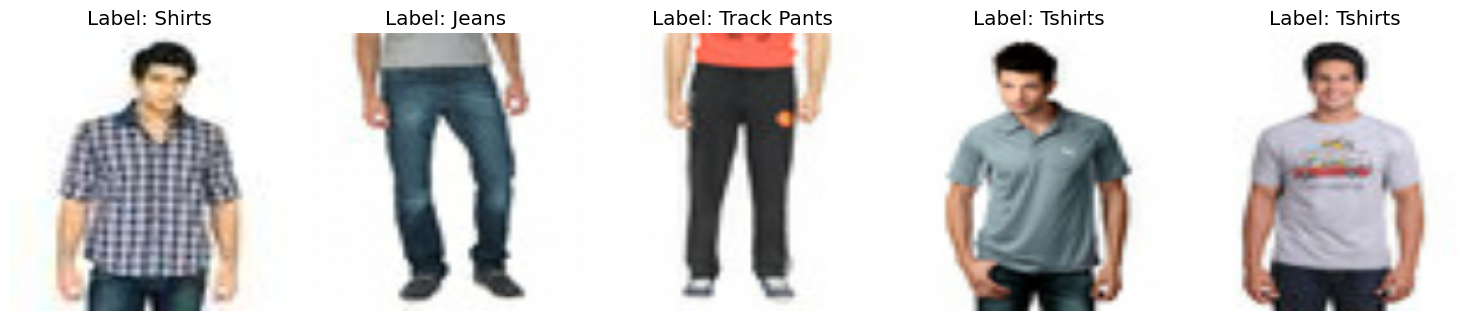

📦 Taille du dataset d'entraînement: 20347
📦 Taille du dataset de test: 5087


In [13]:
# Convert to TensorFlow-friendly data
paths = df['image_path'].tolist()
labels = df['label_index'].tolist()

# Convert to TensorFlow-friendly data
paths = df['image_path'].tolist()
labels = df['label_index'].tolist()

# Create a tf.data.Dataset
ds = tf.data.Dataset.from_tensor_slices((paths, labels))

# display 5 random images with their labels
def display_images(ds, num_images=5):
    plt.figure(figsize=(15, 10))
    for i, (path, label) in enumerate(ds.take(num_images)):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])  # Resize to your model's input size
        img = img / 255.0  # Normalize to [0, 1]
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.numpy())
        plt.title(f"Label: {class_names[label.numpy()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(ds)

# Fonction pour créer un dataset TensorFlow à partir des chemins d'images et des étiquettes
def make_dataset(image_paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    return ds

ds_train = make_dataset(train_df['image_path'].tolist(), train_df['label_index'].tolist())
ds_val = make_dataset(test_df['image_path'].tolist(), test_df['label_index'].tolist())

print(f"📦 Taille du dataset d'entraînement: {len(ds_train)}")
print(f"📦 Taille du dataset de test: {len(ds_val)}")

### 🔍 Exploration du Dataset

Regardons la répartition des données et comprenons la structure :

In [14]:
# 📊 Compter les échantillons dans chaque split
train_size = len(ds_train)
val_size = len(ds_val)

print("📋 Répartition des données:")
print(f"   🎯 Entraînement: {train_size} images ({train_size/(train_size+val_size)*100:.1f}%)")
print(f"   ✅ Validation: {val_size} images ({val_size/(train_size+val_size)*100:.1f}%)")
print(f"   📊 Total: {train_size + val_size} images")

# 🖼️ Examiner une image d'exemple
print("\n🔍 Exemple d'image du dataset:")
for image_path, label in ds_train.take(1):
    # Lire et décoder l'image
    img_raw = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    label_index = int(label.numpy())
    print(f"   📐 Forme de l'image: {img.shape}")
    print(f"   🎨 Type de données: {img.dtype}")
    print(f"   🏷️ Label: {label_index} ({class_names[label_index]})")
    print(f"   📊 Valeurs pixel min/max: {tf.reduce_min(img).numpy()}/{tf.reduce_max(img).numpy()}")

📋 Répartition des données:
   🎯 Entraînement: 20347 images (80.0%)
   ✅ Validation: 5087 images (20.0%)
   📊 Total: 25434 images

🔍 Exemple d'image du dataset:
   📐 Forme de l'image: (80, 60, 3)
   🎨 Type de données: <dtype: 'uint8'>
   🏷️ Label: 28 (Skirts)
   📊 Valeurs pixel min/max: 34/255


2025-06-23 19:41:33.731797: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 🛠️ Préparation des Données

Avant d'entraîner notre modèle, nous devons préparer nos données :

1. **Redimensionner** les images à 224x224 (taille attendue par MobileNetV2)
2. **Normaliser** les pixels selon MobileNetV2
3. **Augmenter** les données d'entraînement
4. **Optimiser** les performances avec batching et prefetching

In [15]:
# 🔧 Fonction de préprocessing
def preprocess_image(filepath, label):
    """
    Préprocesse une image pour MobileNetV2
    
    Args:
        image: Tensor d'image (hauteur, largeur, 3)
        label: Label de l'image
    
    Returns:
        image: Image préprocessée (224, 224, 3)
        label: Label inchangé
    """
    print("🔧 Définition de la fonction de préprocessing...")

    # Load the image from the path and decode
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)

    # ✂️ Redimensionnement à 224x224
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # 🎨 Préprocessing spécifique à MobileNetV2
    # Convertit les pixels de [0, 255] vers [-1, 1]
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    
    return image, label

print("✅ Fonction de préprocessing définie")
print("   🔄 Redimensionnement: Variable → 224x224")
print("   📊 Normalisation: [0, 255] → [-1, 1]")

✅ Fonction de préprocessing définie
   🔄 Redimensionnement: Variable → 224x224
   📊 Normalisation: [0, 255] → [-1, 1]


### 🎲 Data Augmentation

L'augmentation de données aide à améliorer la généralisation en créant des variations des images d'entraînement :

In [19]:
# 🎲 Couches d'augmentation de données
# data_augmentation = keras.Sequential([
#     layers.RandomFlip("horizontal"),        # Retournement horizontal aléatoire
#     layers.RandomRotation(0.2),             # Rotation aléatoire ±20%
#     layers.RandomZoom(0.1),                 # Zoom aléatoire ±10%
# ], name="data_augmentation")

# def augment_image(image, label):
#     """
#     Applique l'augmentation de données pendant l'entraînement
#     """
#     image = data_augmentation(image, training=True)
#     return image, label

# print("🎲 Augmentation de données configurée:")
# print("   ↔️ Retournement horizontal aléatoire")
# print("   🔄 Rotation aléatoire (±36°)")
# print("   🔍 Zoom aléatoire (±10%)")
# print("\n💡 Pourquoi augmenter les données ?")
# print("   • Augmente artificiellement la taille du dataset")
# print("   • Améliore la généralisation du modèle")
# print("   • Réduit le surapprentissage (overfitting)")

### 📊 Application du Pipeline de Données

Maintenant, appliquons toutes nos transformations aux datasets :

In [21]:
# ⚡ Configuration pour l'optimisation des performances
AUTOTUNE = tf.data.AUTOTUNE

print("🔧 Application du pipeline de préparation des données...\n")

# 🎯 Dataset d'entraînement avec augmentation
print("📋 Pipeline d'entraînement:")
ds_train_processed = ds_train.map(preprocess_image, num_parallel_calls=AUTOTUNE)
print("   ✅ 1. Préprocessing appliqué")

# ds_train_processed = ds_train_processed.map(augment_image, num_parallel_calls=AUTOTUNE)
# print("   ✅ 2. Augmentation appliquée")

ds_train_processed = ds_train_processed.batch(BATCH_SIZE)
print("   ✅ 3. Batching appliqué")

ds_train_processed = ds_train_processed.prefetch(AUTOTUNE)
print("   ✅ 4. Prefetching appliqué")

# 🎯 Dataset de validation SANS augmentation
print("\n📋 Pipeline de validation:")
ds_val_processed = ds_val.map(preprocess_image, num_parallel_calls=AUTOTUNE)
print("   ✅ 1. Préprocessing appliqué (SANS augmentation)")

ds_val_processed = ds_val_processed.batch(BATCH_SIZE)
print("   ✅ 2. Batching appliqué")

ds_val_processed = ds_val_processed.prefetch(AUTOTUNE)
print("   ✅ 3. Prefetching appliqué")

print("\n💡 Pourquoi pas d'augmentation en validation ?")
print("   • La validation doit être reproductible")
print("   • Nous voulons évaluer sur les données 'réelles'")
print("   • L'augmentation ne sert qu'à enrichir l'entraînement")

🔧 Application du pipeline de préparation des données...

📋 Pipeline d'entraînement:
🔧 Définition de la fonction de préprocessing...
   ✅ 1. Préprocessing appliqué
   ✅ 3. Batching appliqué
   ✅ 4. Prefetching appliqué

📋 Pipeline de validation:
🔧 Définition de la fonction de préprocessing...
   ✅ 1. Préprocessing appliqué (SANS augmentation)
   ✅ 2. Batching appliqué
   ✅ 3. Prefetching appliqué

💡 Pourquoi pas d'augmentation en validation ?
   • La validation doit être reproductible
   • Nous voulons évaluer sur les données 'réelles'
   • L'augmentation ne sert qu'à enrichir l'entraînement


## 🎨 Visualisation des Données

Visualisons nos données avant et après préprocessing pour bien comprendre les transformations :

In [22]:
def show_batch(dataset, title="Batch d'images", num_images=9, figsize=(12, 12)):
    """
    Visualise un batch d'images avec leurs labels
    
    Args:
        dataset: Dataset TensorFlow
        title: Titre du graphique
        num_images: Nombre d'images à afficher
        figsize: Taille de la figure
    """
    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=16, fontweight='bold')
    
    for images, labels in dataset.take(1):
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            
            # Récupérer et préparer l'image pour l'affichage
            image = images[i].numpy()
            
            # Si l'image est normalisée [-1, 1], la ramener à [0, 1]
            if image.min() < 0:
                image = (image + 1) / 2
            
            # Si les valeurs sont > 1, normaliser
            if image.max() > 1:
                image = image / 255.0
            
            plt.imshow(image)
            plt.title(f"{class_names[labels[i]]}", fontsize=12, pad=10)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("🎨 Fonction de visualisation créée")

🎨 Fonction de visualisation créée


### 🖼️ Images Originales

Regardons d'abord les images telles qu'elles sont dans le dataset original :

🌸 Aperçu des images originales du dataset:
ℹ️ Note: Images redimensionnées à 224x224 pour permettre l'affichage en batch


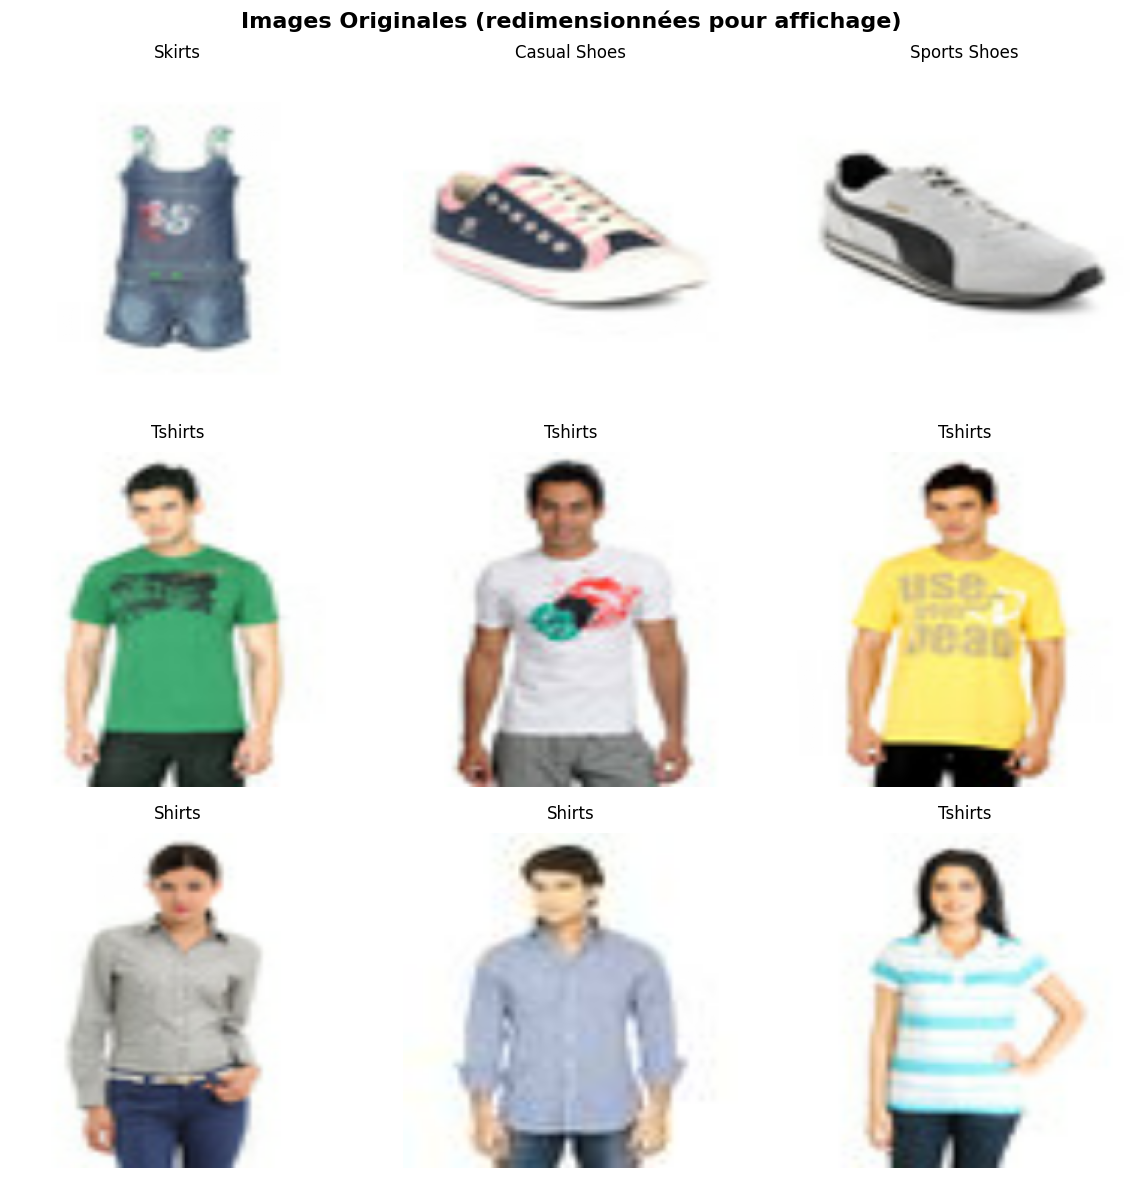

In [23]:
# 🖼️ Fonction de redimensionnement simple pour la visualisation
def resize_for_display(filepath, label):
    """Redimensionne uniquement pour l'affichage (pas de normalisation)"""
    # Load the image from the path and decode
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)


    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# 🖼️ Affichage des images originales (redimensionnées pour l'affichage)
print("🌸 Aperçu des images originales du dataset:")
print("ℹ️ Note: Images redimensionnées à 224x224 pour permettre l'affichage en batch")
ds_train_display = ds_train.map(resize_for_display).batch(9)
show_batch(ds_train_display, title="Images Originales (redimensionnées pour affichage)")

### 🔄 Images Après Préprocessing

Maintenant, voyons les mêmes images après redimensionnement et normalisation :

🔧 Définition de la fonction de préprocessing...
🔧 Aperçu après préprocessing (redimensionnement + normalisation):


2025-06-23 19:52:26.823252: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


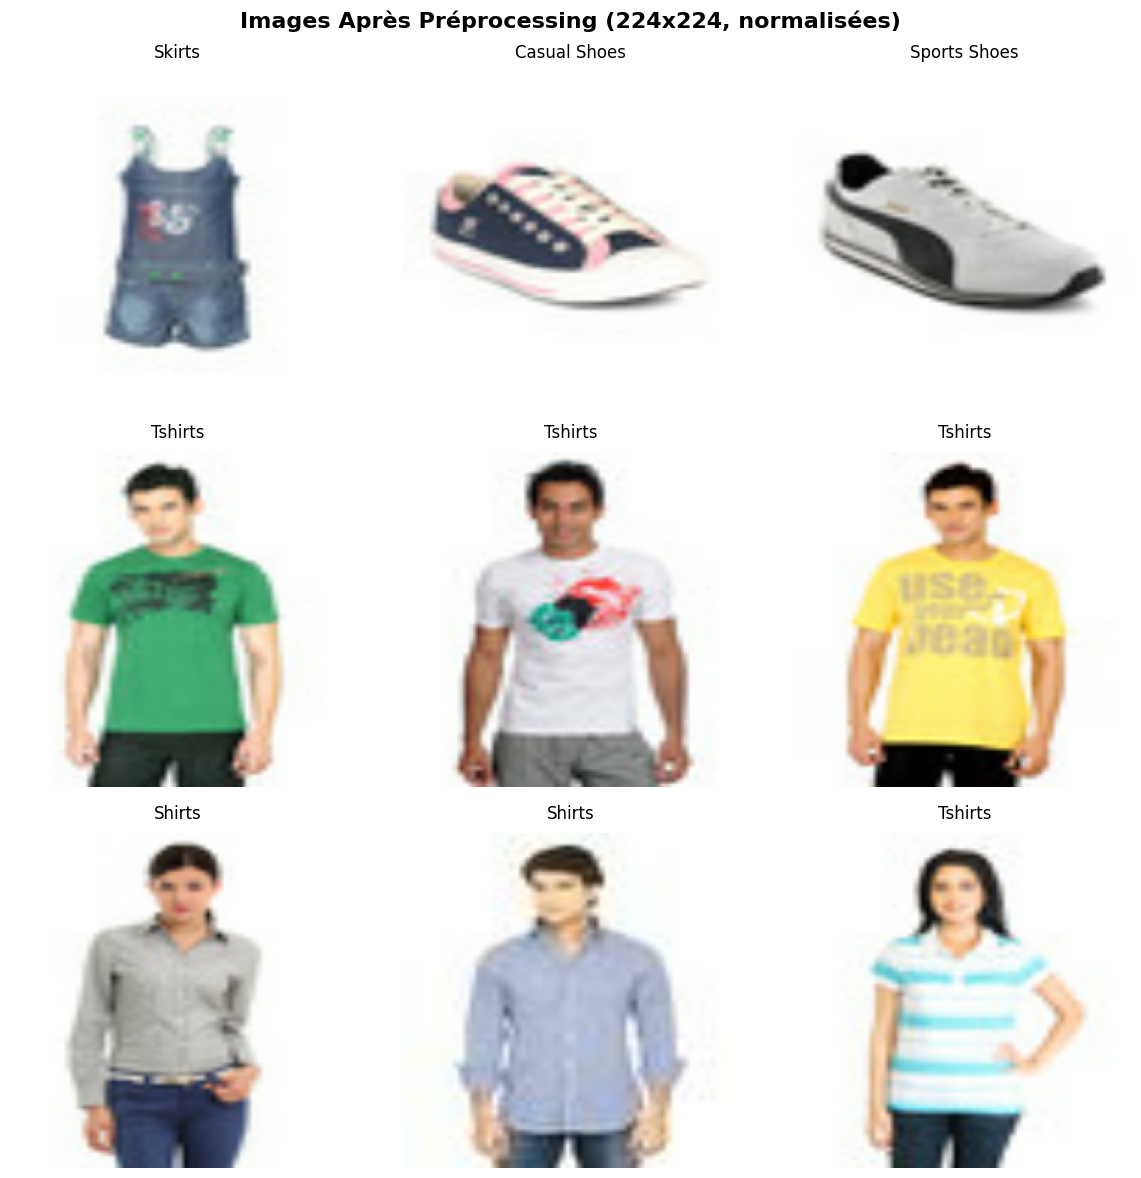

In [24]:
# 🔄 Affichage après préprocessing (sans augmentation)
ds_preprocessed_only = ds_train.map(preprocess_image).batch(9)
print("🔧 Aperçu après préprocessing (redimensionnement + normalisation):")
show_batch(ds_preprocessed_only, title="Images Après Préprocessing (224x224, normalisées)")

### 🎲 Effet de l'Augmentation de Données

Comparons la même image avant et après augmentation pour voir l'effet des transformations :

🎲 Démonstration de l'augmentation de données:
🔧 Définition de la fonction de préprocessing...


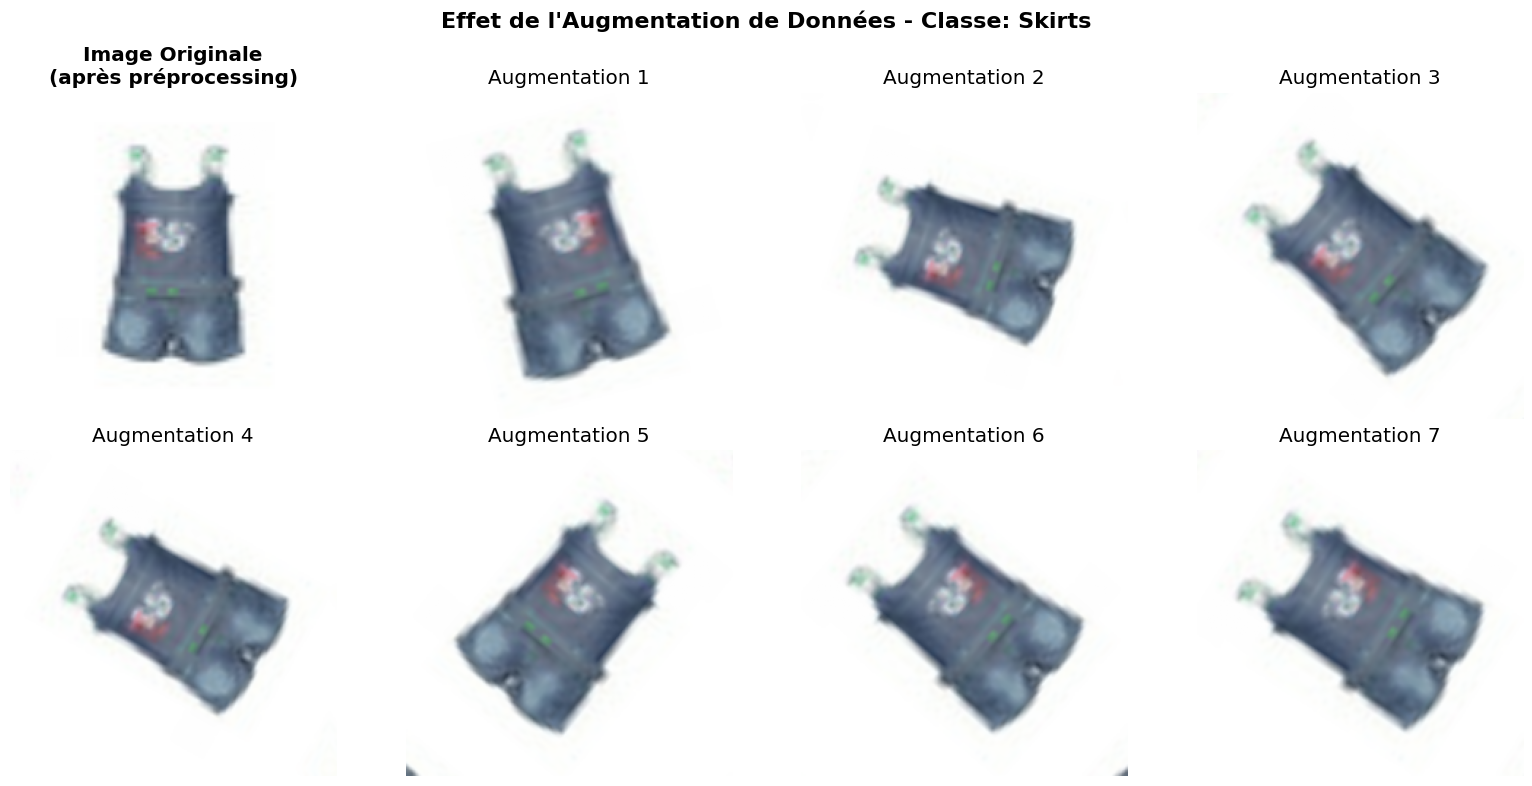


💡 Observations sur l'augmentation:
   🔄 Chaque version est légèrement différente
   📊 Cela multiplie artificiellement notre dataset
   🎯 Le modèle apprend à être plus robuste aux variations


In [26]:
# 🎲 Démonstration de l'augmentation de données
def show_augmentation_effect():
    """
    Montre l'effet de l'augmentation sur une même image
    """
    # Prendre une seule image
    for original_image, label in ds_train.take(1):
        # Préprocesser l'image
        processed_image, _ = preprocess_image(original_image, label)
        
        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle(f"Effet de l'Augmentation de Données - Classe: {class_names[label]}", 
                    fontsize=16, fontweight='bold')
        
        # Image originale préprocessée
        axes[0, 0].imshow((processed_image + 1) / 2)
        axes[0, 0].set_title("Image Originale\n(après préprocessing)", fontweight='bold')
        axes[0, 0].axis('off')
        
        # Générer plusieurs versions augmentées
        for i in range(1, 4):
            augmented_image, _ = augment_image(processed_image, label)
            axes[0, i].imshow((augmented_image + 1) / 2)
            axes[0, i].set_title(f"Augmentation {i}")
            axes[0, i].axis('off')
        
        # Encore plus d'exemples
        for i in range(4):
            augmented_image, _ = augment_image(processed_image, label)
            axes[1, i].imshow((augmented_image + 1) / 2)
            axes[1, i].set_title(f"Augmentation {i+4}")
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        break

print("🎲 Démonstration de l'augmentation de données:")
show_augmentation_effect()

print("\n💡 Observations sur l'augmentation:")
print("   🔄 Chaque version est légèrement différente")
print("   📊 Cela multiplie artificiellement notre dataset")
print("   🎯 Le modèle apprend à être plus robuste aux variations")

### 📊 Aperçu Final des Données d'Entraînement

Regardons maintenant un batch complet tel qu'il sera fourni au modèle :

🎯 Aperçu final du dataset d'entraînement (avec toutes les transformations):


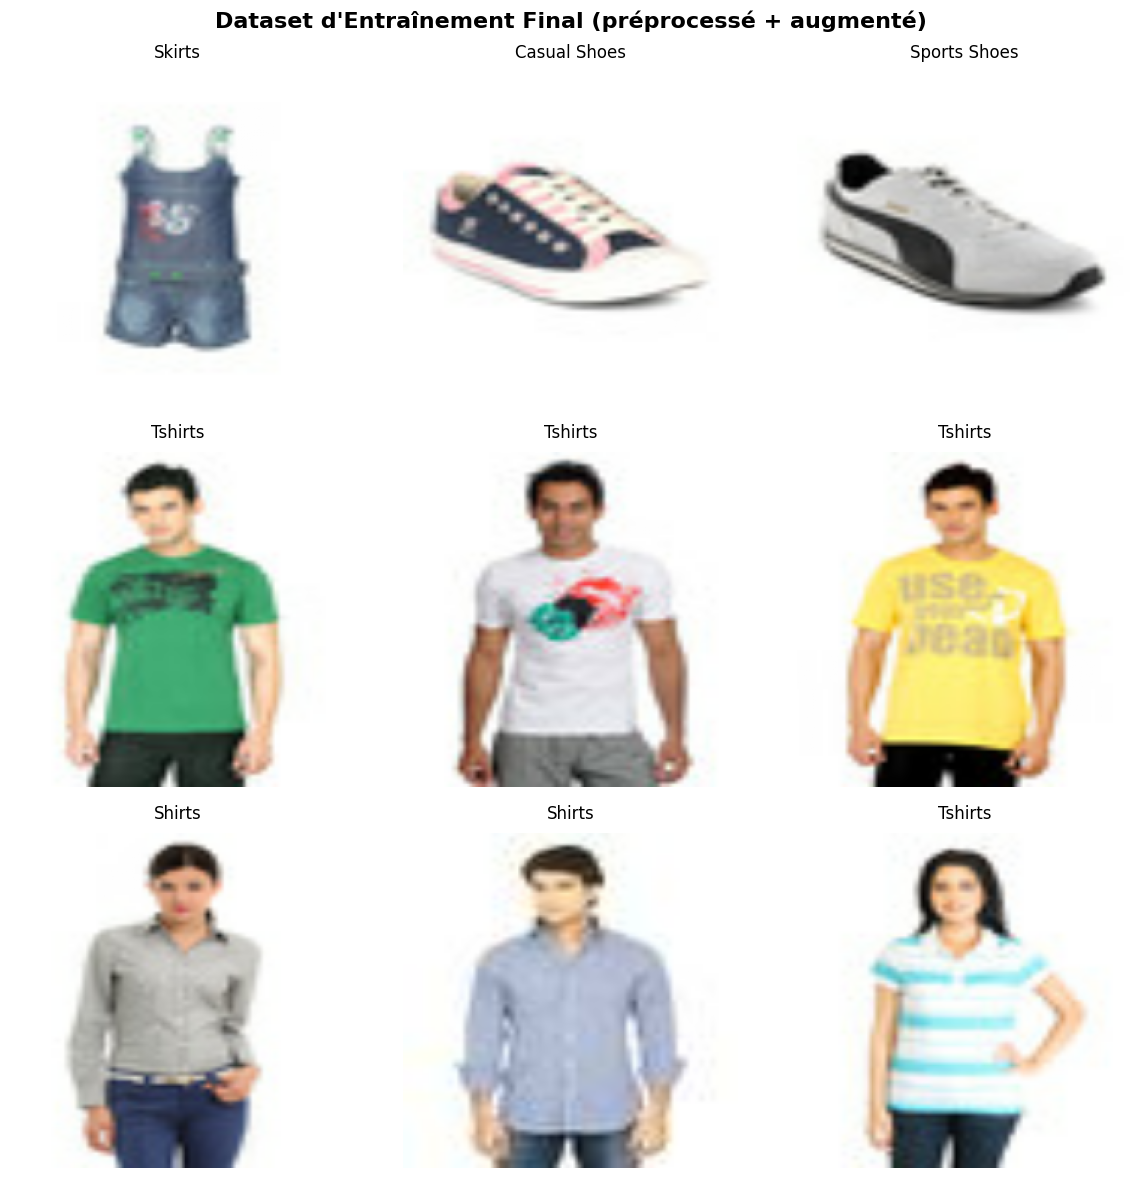


📋 Résumé de ce que le modèle va recevoir:
   📐 Taille: 224x224x3 pixels
   📊 Valeurs: [-1, 1] (normalisées pour MobileNetV2)
   🎲 Variété: Augmentées aléatoirement à chaque époque
   📦 Batch: 32 images à la fois


In [27]:
# 📊 Affichage du dataset final d'entraînement
print("🎯 Aperçu final du dataset d'entraînement (avec toutes les transformations):")
show_batch(ds_train_processed, title="Dataset d'Entraînement Final (préprocessé + augmenté)")

print("\n📋 Résumé de ce que le modèle va recevoir:")
print("   📐 Taille: 224x224x3 pixels")
print("   📊 Valeurs: [-1, 1] (normalisées pour MobileNetV2)")
print("   🎲 Variété: Augmentées aléatoirement à chaque époque")
print("   📦 Batch: 32 images à la fois")

## 🧠 Création du Modèle avec Transfer Learning

Maintenant que nos données sont prêtes, créons notre modèle basé sur MobileNetV2 pré-entraîné.

### 🎯 Qu'est-ce que MobileNetV2 ?

- **Architecture légère** optimisée pour mobile
- **Pré-entraîné sur ImageNet** (1.4M d'images, 1000 classes)
- **Excellent équilibre** entre performance et vitesse
- **Idéal pour le fine-tuning** sur de nouveaux domaines

In [28]:
# 🧠 Chargement du modèle de base MobileNetV2
print("🚀 Chargement de MobileNetV2 pré-entraîné...")

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),  # Forme d'entrée
    include_top=False,                    # Exclure la couche de classification finale
    weights='imagenet'                    # Utiliser les poids pré-entraînés ImageNet
)

# 🔒 Geler les couches du modèle de base (transfer learning)
base_model.trainable = False

print("✅ MobileNetV2 chargé avec succès !")
print(f"📊 Nombre de couches: {len(base_model.layers)}")
print(f"📐 Forme de sortie: {base_model.output_shape}")
print(f"🔒 Couches gelées: {not base_model.trainable}")

# 💡 Explication pédagogique
print("\n🎓 Pourquoi geler les couches ?")
print("   • Les features bas niveau (bords, textures) sont déjà bien apprises")
print("   • Évite de 'casser' les représentations pré-entraînées")
print("   • Accélère l'entraînement initial")
print("   • Nous dégelerons certaines couches plus tard (fine-tuning)")

🚀 Chargement de MobileNetV2 pré-entraîné...
✅ MobileNetV2 chargé avec succès !
📊 Nombre de couches: 154
📐 Forme de sortie: (None, 7, 7, 1280)
🔒 Couches gelées: True

🎓 Pourquoi geler les couches ?
   • Les features bas niveau (bords, textures) sont déjà bien apprises
   • Évite de 'casser' les représentations pré-entraînées
   • Accélère l'entraînement initial
   • Nous dégelerons certaines couches plus tard (fine-tuning)


### 🏗️ Architecture Complète du Modèle

Ajoutons nos propres couches au-dessus du modèle pré-entraîné :

In [ ]:
# 🏗️ Construction du modèle complet
print("🔧 Construction de l'architecture complète...")

# Couche d'entrée
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Modèle de base (gelé)
x = base_model(inputs, training=False)  # training=False pour utiliser en mode inférence

# Pooling global pour réduire les dimensions
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Couche de dropout pour la régularisation
x = tf.keras.layers.Dropout(0.2)(x)

# Couche de classification finale
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
# Création du modèle final
model = tf.keras.Model(inputs, outputs)

print("✅ Modèle créé avec succès !")

# Calculer les paramètres de manière compatible TensorFlow
total_params = model.count_params()
trainable_params = sum(tf.size(var).numpy() for var in model.trainable_variables)
frozen_params = total_params - trainable_params

print(f"📊 Nombre total de paramètres: {total_params:,}")
print(f"🎯 Paramètres entraînables: {trainable_params:,}")
print(f"🔒 Paramètres gelés: {frozen_params:,}")


🔧 Construction de l'architecture complète...
✅ Modèle créé avec succès !
📊 Nombre total de paramètres: 2,313,067
🎯 Paramètres entraînables: 55,083
🔒 Paramètres gelés: 2,257,984


[<InputLayer name=input_layer_5, built=True>,
 <Functional name=mobilenetv2_1.00_224, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d_3, built=True>,
 <Dropout name=dropout_3, built=True>,
 <Dense name=dense_3, built=True>]

### 📋 Résumé de l'Architecture

Visualisons l'architecture de notre modèle :

In [30]:
# 📋 Affichage du résumé du modèle
print("🏗️ Architecture du modèle:")
model.summary()

print("\n🎓 Explication de l'architecture:")
print("   📥 Input (224, 224, 3): Image d'entrée")
print("   🧠 MobileNetV2: Extraction de features (gelé)")
print("   🌐 GlobalAveragePooling2D: Réduction dimensionnelle")
print("   🎲 Dropout(0.2): Régularisation (20% de neurones désactivés)")
print(f"   🎯 Dense({num_classes}, softmax): Classification finale ({num_classes} classes de vêtements)")

🏗️ Architecture du modèle:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 43)             │        55,083 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,313,067 (8.82 MB)

 Trainable params: 55,083 (215.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


🎓 Explication de l'architecture:
   📥 Input (224, 224, 3): Image d'entrée
   🧠 MobileNetV2: Extraction de features (gelé)
   🌐 GlobalAveragePooling2D: Réduction dimensionnelle
   🎲 Dropout(0.2): Régularisation (20% de neurones désactivés)
   🎯 Dense(43, softmax): Classification finale (43 classes de vêtements)


### 🎯 Visualisation de l'Architecture

Créons un diagramme pour mieux comprendre notre modèle :

🎨 Visualisation de l'architecture du modèle:


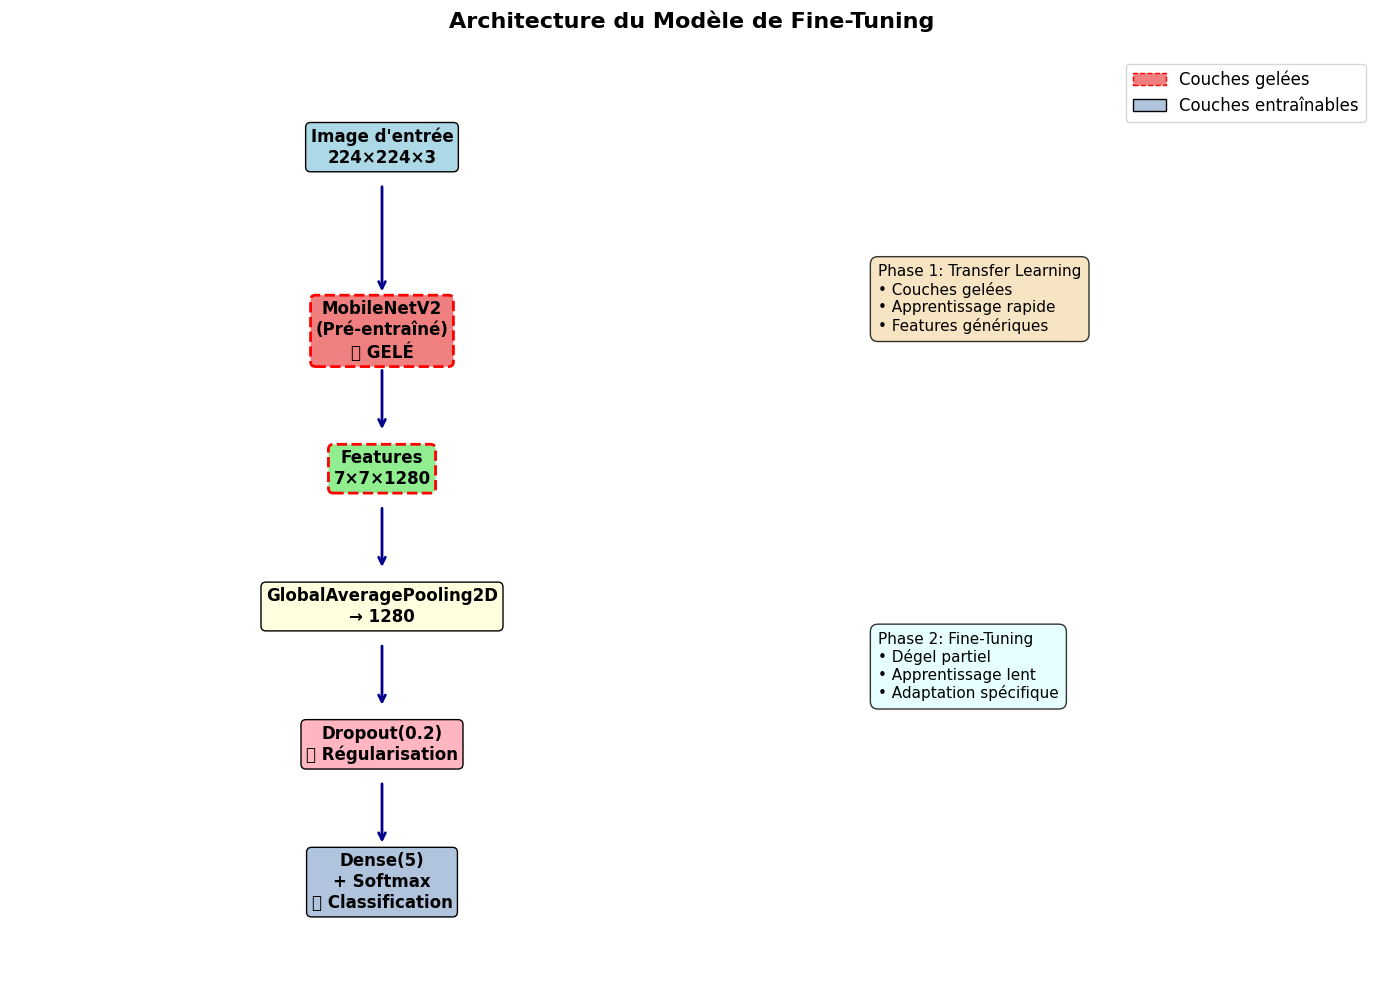


💡 Points clés de l'architecture:
   🔒 MobileNetV2 gelé: Préserve les features pré-apprises
   🎯 Nouvelles couches: Adaptées à notre problème (5 classes)
   ⚡ Efficace: Peu de paramètres à entraîner initialement
   🎲 Régularisation: Dropout pour éviter l'overfitting


In [50]:
# 🎨 Visualisation de l'architecture
def visualize_model_architecture():
    """
    Crée un diagramme explicatif de l'architecture
    """
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Définir les composants et leurs positions
    components = [
        {"name": "Image d'entrée\n224×224×3", "pos": (1, 8), "color": "lightblue", "frozen": False},
        {"name": "MobileNetV2\n(Pré-entraîné)\n🔒 GELÉ", "pos": (1, 6), "color": "lightcoral", "frozen": True},
        {"name": "Features\n7×7×1280", "pos": (1, 4.5), "color": "lightgreen", "frozen": True},
        {"name": "GlobalAveragePooling2D\n→ 1280", "pos": (1, 3), "color": "lightyellow", "frozen": False},
        {"name": "Dropout(0.2)\n🎲 Régularisation", "pos": (1, 1.5), "color": "lightpink", "frozen": False},
        {"name": "Dense(5)\n+ Softmax\n🎯 Classification", "pos": (1, 0), "color": "lightsteelblue", "frozen": False}
    ]
    
    # Dessiner les composants
    for i, comp in enumerate(components):
        x, y = comp["pos"]
        
        # Style différent pour les couches gelées
        if comp["frozen"]:
            bbox_props = dict(boxstyle="round,pad=0.3", facecolor=comp["color"], 
                            edgecolor="red", linewidth=2, linestyle="--")
        else:
            bbox_props = dict(boxstyle="round,pad=0.3", facecolor=comp["color"], 
                            edgecolor="black", linewidth=1)
        
        ax.text(x, y, comp["name"], ha="center", va="center", 
               fontsize=12, fontweight="bold", bbox=bbox_props)
        
        # Flèches entre composants
        if i < len(components) - 1:
            next_y = components[i+1]["pos"][1]
            ax.annotate("", xy=(x, next_y + 0.4), xytext=(x, y - 0.4),
                       arrowprops=dict(arrowstyle="->", lw=2, color="darkblue"))
    
    # Annotations explicatives
    ax.text(3, 6, "Phase 1: Transfer Learning\n• Couches gelées\n• Apprentissage rapide\n• Features génériques", 
           fontsize=11, bbox=dict(boxstyle="round,pad=0.5", facecolor="wheat", alpha=0.8))
    
    ax.text(3, 2, "Phase 2: Fine-Tuning\n• Dégel partiel\n• Apprentissage lent\n• Adaptation spécifique", 
           fontsize=11, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcyan", alpha=0.8))
    
    # Configuration des axes
    ax.set_xlim(-0.5, 5)
    ax.set_ylim(-1, 9)
    ax.set_title("Architecture du Modèle de Fine-Tuning", fontsize=16, fontweight="bold", pad=20)
    ax.axis('off')
    
    # Légende
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='lightcoral', edgecolor='red', linestyle='--', label='Couches gelées'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightsteelblue', edgecolor='black', label='Couches entraînables')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

print("🎨 Visualisation de l'architecture du modèle:")
visualize_model_architecture()

print("\n💡 Points clés de l'architecture:")
print("   🔒 MobileNetV2 gelé: Préserve les features pré-apprises")
print("   🎯 Nouvelles couches: Adaptées à notre problème (5 classes)")
print("   ⚡ Efficace: Peu de paramètres à entraîner initialement")
print("   🎲 Régularisation: Dropout pour éviter l'overfitting")

## 🎯 Phase 1 : Transfer Learning (Couches Gelées)

Nous allons maintenant entraîner notre modèle en deux phases :

1. **Phase 1** : Transfer Learning avec couches gelées
2. **Phase 2** : Fine-Tuning avec dégel partiel

### 🔒 Pourquoi Commencer avec les Couches Gelées ?

- ⚡ **Entraînement rapide** : Moins de paramètres à mettre à jour
- 🛡️ **Préservation des features** : Évite de "casser" les représentations pré-apprises
- 🎯 **Adaptation douce** : Les nouvelles couches apprennent d'abord à utiliser les features existantes
- 💾 **Économie de ressources** : Moins de mémoire et calculs nécessaires

In [34]:
# ⚙️ Configuration de l'entraînement Phase 1
print("🎯 === PHASE 1: TRANSFER LEARNING (couches gelées) ===")
print("\n🔧 Configuration de l'optimiseur et des métriques...")

# Compilation du modèle
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',  # Pour labels entiers (0, 1, 2, 3, 4)
    metrics=['accuracy']
)

print("✅ Modèle compilé !")
print(f"   🧠 Optimiseur: Adam (lr={LEARNING_RATE})")
print(f"   📊 Fonction de perte: Sparse Categorical Crossentropy")
print(f"   📈 Métriques: Accuracy")

# 🎓 Explication pédagogique
print("\n🎓 Pourquoi ces choix ?")
print("   • Adam: Optimiseur adaptatif, bon pour la plupart des cas")
print("   • Sparse Categorical: Nos labels sont des entiers (0,1,2,3,4)")
print("   • Learning rate faible: Pour ne pas perturber les features pré-entraînées")

🎯 === PHASE 1: TRANSFER LEARNING (couches gelées) ===

🔧 Configuration de l'optimiseur et des métriques...
✅ Modèle compilé !
   🧠 Optimiseur: Adam (lr=0.0001)
   📊 Fonction de perte: Sparse Categorical Crossentropy
   📈 Métriques: Accuracy

🎓 Pourquoi ces choix ?
   • Adam: Optimiseur adaptatif, bon pour la plupart des cas
   • Sparse Categorical: Nos labels sont des entiers (0,1,2,3,4)
   • Learning rate faible: Pour ne pas perturber les features pré-entraînées


### 📊 Callbacks pour l'Entraînement

Les callbacks nous aident à surveiller et contrôler l'entraînement :

In [35]:
# 🔧 Configuration des callbacks
callbacks = [
    # Réduction du learning rate si la perte stagne
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',           # Surveiller la perte de validation
        factor=0.2,                   # Diviser le LR par 5 (×0.2)
        patience=3,                   # Attendre 3 époques sans amélioration
        min_lr=1e-7,                  # LR minimum
        verbose=1
    ),
    
    # Arrêt anticipé si pas d'amélioration
    keras.callbacks.EarlyStopping(
        monitor='val_loss',           # Surveiller la perte de validation
        patience=5,                   # Attendre 5 époques sans amélioration
        restore_best_weights=True,    # Restaurer les meilleurs poids
        verbose=1
    )
]

print("🔧 Callbacks configurés:")
print("   📉 ReduceLROnPlateau: Réduit automatiquement le learning rate")
print("   ⏹️ EarlyStopping: Arrête l'entraînement si pas d'amélioration")
print("\n💡 Avantages des callbacks:")
print("   • Évitent le surapprentissage")
print("   • Économisent du temps de calcul")
print("   • Trouvent automatiquement les meilleurs hyperparamètres")

🔧 Callbacks configurés:
   📉 ReduceLROnPlateau: Réduit automatiquement le learning rate
   ⏹️ EarlyStopping: Arrête l'entraînement si pas d'amélioration

💡 Avantages des callbacks:
   • Évitent le surapprentissage
   • Économisent du temps de calcul
   • Trouvent automatiquement les meilleurs hyperparamètres


### 🚀 Lancement de l'Entraînement Phase 1

C'est parti pour la première phase d'entraînement !

In [36]:
# 🚀 Entraînement Phase 1
print("🚀 Début de l'entraînement Phase 1...")
# print(f"📊 {sum(1 for _ in ds_train_processed)} batches d'entraînement")
# print(f"📊 {sum(1 for _ in ds_val_processed)} batches de validation")
print("\n⏰ Cela peut prendre quelques minutes...\n")

# Entraînement
history = model.fit(
    ds_train_processed,
    epochs=EPOCHS,
    validation_data=ds_val_processed,
    callbacks=callbacks,
    verbose=1
)

print("\n🎉 Phase 1 terminée !")
print(f"✅ Nombre d'époques effectuées: {len(history.history['accuracy'])}")
print(f"📈 Précision finale d'entraînement: {history.history['accuracy'][-1]:.4f}")
print(f"📊 Précision finale de validation: {history.history['val_accuracy'][-1]:.4f}")

🚀 Début de l'entraînement Phase 1...

⏰ Cela peut prendre quelques minutes...

Epoch 1/10


I0000 00:00:1750702210.483800  763506 service.cc:152] XLA service 0x17cae990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750702210.483884  763506 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-06-23 20:10:10.556904: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750702211.064101  763506 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-23 20:10:11.894001: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1864', 312 bytes spill stores, 312 bytes spill loads



 10/636 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.0195 - loss: 4.1894

I0000 00:00:1750702216.445911  763506 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


633/636 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3945 - loss: 2.2292

2025-06-23 20:10:28.601266: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1864', 304 bytes spill stores, 304 bytes spill loads



636/636 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3952 - loss: 2.2263

2025-06-23 20:10:34.113853: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1167', 84 bytes spill stores, 84 bytes spill loads

2025-06-23 20:10:34.514098: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1167', 3740 bytes spill stores, 3732 bytes spill loads

2025-06-23 20:10:34.567678: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1167', 1604 bytes spill stores, 1604 bytes spill loads

2025-06-23 20:10:34.659989: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1167', 6092 bytes spill stores, 6048 bytes spill loads

2025-06-23 20:10:42.682110: 

636/636 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.3954 - loss: 2.2253 - val_accuracy: 0.7100 - val_loss: 0.9708 - learning_rate: 1.0000e-04
Epoch 2/10
636/636 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7041 - loss: 0.9622 - val_accuracy: 0.7484 - val_loss: 0.7697 - learning_rate: 1.0000e-04
Epoch 3/10
636/636 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.7457 - loss: 0.7798 - val_accuracy: 0.7688 - val_loss: 0.6861 - learning_rate: 1.0000e-04
Epoch 4/10
636/636 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7634 - loss: 0.6989 - val_accuracy: 0.7832 - val_loss: 0.6375 - learning_rate: 1.0000e-04
Epoch 5/10
636/636 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.7777 - loss: 0.6456 - val_accuracy: 0.7908 - val_loss: 0.6061 - learning_rate: 1.0000e-04
Epoch 6/10
636/636 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.7902 - loss: 0.6088 - val_accuracy: 0.7950 - val_loss: 0.5832 - learning_rate: 1.0000e-04
Epoch 7/10
636/636 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accurac

## 🔓 Phase 2 : Fine-Tuning (Dégel Partiel)

Maintenant que notre modèle a appris à utiliser les features de MobileNetV2, nous allons **dégeler** certaines couches pour un ajustement plus fin.

### 🎯 Stratégie de Dégel

- 🔓 **Dégeler les dernières couches** : Elles contiennent les features plus spécifiques
- 🔒 **Garder gelées les premières couches** : Elles contiennent les features génériques (bords, textures)
- 📉 **Réduire le learning rate** : Pour des ajustements plus fins

In [ ]:
# 🔍 Analyse des couches de MobileNetV2
print("🔍 Analyse des couches de MobileNetV2:")
print(f"📊 Nombre total de couches: {len(base_model.layers)}")

# Afficher quelques couches pour comprendre la structure
print("\n🏗️ Structure des couches (dernières 10):")
for i, layer in enumerate(base_model.layers[-20:]):
    print(f"   {len(base_model.layers)-20+i:3d}: {layer.name} ({layer.__class__.__name__})")

# 🔓 Stratégie de dégel : dégeler les 20 dernières couches
fine_tune_at = len(base_model.layers) - 20

print(f"\n🎯 Stratégie de dégel:")
print(f"   🔒 Couches 0 à {fine_tune_at-1}: GELÉES (features génériques)")
print(f"   🔓 Couches {fine_tune_at} à {len(base_model.layers)-1}: DÉGELÉES (features spécifiques)")

🔍 Analyse des couches de MobileNetV2:
📊 Nombre total de couches: 154

🏗️ Structure des couches (dernières 10):
   144: block_16_expand_BN (BatchNormalization)
   145: block_16_expand_relu (ReLU)
   146: block_16_depthwise (DepthwiseConv2D)
   147: block_16_depthwise_BN (BatchNormalization)
   148: block_16_depthwise_relu (ReLU)
   149: block_16_project (Conv2D)
   150: block_16_project_BN (BatchNormalization)
   151: Conv_1 (Conv2D)
   152: Conv_1_bn (BatchNormalization)
   153: out_relu (ReLU)

🎯 Stratégie de dégel:
   🔒 Couches 0 à 133: GELÉES (features génériques)
   🔓 Couches 134 à 153: DÉGELÉES (features spécifiques)


In [ ]:
# 🔓 Application du dégel
print("🔧 Application de la stratégie de dégel...")

# Dégeler le modèle de base
base_model.trainable = True

# Geler les premières couches, dégeler les dernières
for i, layer in enumerate(base_model.layers):
    if i < fine_tune_at:
        layer.trainable = False  # Garder gelé
    else:
        layer.trainable = True   # Dégeler

# Compter les paramètres entraînables
trainable_params = sum(tf.size(var).numpy() for var in model.trainable_variables)
total_params = model.count_params()

print("✅ Dégel appliqué !")
print(f"📊 Paramètres entraînables: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
print(f"🔒 Paramètres gelés: {total_params-trainable_params:,} ({(total_params-trainable_params)/total_params*100:.1f}%)")
print(f"📈 Total: {total_params:,} paramètres")

🔧 Application de la stratégie de dégel...
✅ Dégel appliqué !
📊 Paramètres entraînables: 1,209,923 (53.5%)
🔒 Paramètres gelés: 1,051,904 (46.5%)
📈 Total: 2,261,827 paramètres


### ⚙️ Recompilation avec Learning Rate Réduit

Pour le fine-tuning, nous utilisons un learning rate plus faible :

In [ ]:
# ⚙️ Recompilation avec learning rate réduit
fine_tune_lr = LEARNING_RATE / 10  # Diviser par 10

print(f"🔧 Recompilation du modèle pour le fine-tuning...")
print(f"📉 Nouveau learning rate: {fine_tune_lr} (10x plus faible)")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Modèle recompilé !")
print("\n💡 Pourquoi un learning rate plus faible ?")
print("   • Les features pré-entraînées sont déjà bonnes")
print("   • On veut des ajustements fins, pas des changements drastiques")
print("   • Évite de 'casser' ce qui a été appris en Phase 1")

🔧 Recompilation du modèle pour le fine-tuning...
📉 Nouveau learning rate: 1e-05 (10x plus faible)
✅ Modèle recompilé !

💡 Pourquoi un learning rate plus faible ?
   • Les features pré-entraînées sont déjà bonnes
   • On veut des ajustements fins, pas des changements drastiques
   • Évite de 'casser' ce qui a été appris en Phase 1


### 🚀 Lancement du Fine-Tuning

Continuons l'entraînement avec les couches dégelées :

In [ ]:
# 🚀 Entraînement Phase 2 (Fine-tuning)
print("🚀 === PHASE 2: FINE-TUNING (couches dégelées) ===")
print("\n⏰ Début du fine-tuning...")

# Continuer l'entraînement depuis la dernière époque
initial_epoch = len(history.history['accuracy'])
total_epochs = initial_epoch + EPOCHS

print(f"📊 Reprendre depuis l'époque: {initial_epoch}")
print(f"🎯 Aller jusqu'à l'époque: {total_epochs}")
print(f"➕ Époque supplémentaires: {EPOCHS}")

# Fine-tuning
history_fine = model.fit(
    ds_train_processed,
    epochs=total_epochs,
    initial_epoch=initial_epoch,
    validation_data=ds_val_processed,
    callbacks=callbacks,
    verbose=1
)

print("\n🎉 Fine-tuning terminé !")
print(f"✅ Époques totales effectuées: {len(history.history['accuracy']) + len(history_fine.history['accuracy'])}")
print(f"📈 Précision finale d'entraînement: {history_fine.history['accuracy'][-1]:.4f}")
print(f"📊 Précision finale de validation: {history_fine.history['val_accuracy'][-1]:.4f}")

🚀 === PHASE 2: FINE-TUNING (couches dégelées) ===

⏰ Début du fine-tuning...
📊 Reprendre depuis l'époque: 10
🎯 Aller jusqu'à l'époque: 20
➕ Époque supplémentaires: 10
Epoch 11/20
636/636 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 0.9969 - val_loss: 0.0158 - learning_rate: 2.0000e-06
Epoch 12/20
636/636 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 0.9969 - val_loss: 0.0157 - learning_rate: 2.0000e-06
Epoch 13/20
636/636 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9998 - loss: 0.0015 - val_accuracy: 0.9972 - val_loss: 0.0161 - learning_rate: 2.0000e-06
Epoch 14/20
634/636 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9998 - loss: 0.0011
Epoch 14: ReduceLROnPlateau reducing learning rate to 3.999999989900971e-07.
636/636 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9972 - val_loss: 0.0161 - learning_rate: 2.0000e-06
Epoch 15/20
636/636 ━━━━━━━━━━━━━━━━━━━━ 14s

## 📊 Visualisation des Résultats d'Entraînement

Analysons maintenant les performances de notre modèle à travers les deux phases d'entraînement.

### 📈 Importance de la Visualisation

Les graphiques nous permettent de :
- **Détecter le surapprentissage** (overfitting)
- **Comprendre l'évolution** de l'apprentissage
- **Valider l'efficacité** du fine-tuning
- **Identifier les problèmes** potentiels

In [ ]:
def plot_training_history(history1, history2=None, title="Évolution de l'Entraînement"):
    """
    Affiche les courbes d'entraînement pour les deux phases
    
    Args:
        history1: Historique de la Phase 1 (Transfer Learning)
        history2: Historique de la Phase 2 (Fine-Tuning) - optionnel
        title: Titre du graphique
    """
    # Préparer les données
    if history2:
        # Combiner les deux phases
        acc = history1.history['accuracy'] + history2.history['accuracy']
        val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
        loss = history1.history['loss'] + history2.history['loss']
        val_loss = history1.history['val_loss'] + history2.history['val_loss']
        
        # Point de transition entre les phases
        transition_point = len(history1.history['accuracy']) - 1
        
        phases_info = True
    else:
        # Une seule phase
        acc = history1.history['accuracy']
        val_acc = history1.history['val_accuracy']
        loss = history1.history['loss']
        val_loss = history1.history['val_loss']
        
        phases_info = False
    
    epochs_range = range(len(acc))
    
    # Créer la figure avec 2 sous-graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # Graphique 1: Précision
    ax1.plot(epochs_range, acc, 'b-', label='Entraînement', linewidth=2)
    ax1.plot(epochs_range, val_acc, 'r-', label='Validation', linewidth=2)
    
    if phases_info:
        # Ligne de séparation entre les phases
        ax1.axvline(x=transition_point, color='green', linestyle='--', 
                   linewidth=2, label='Début Fine-Tuning')
        
        # Zones colorées pour les phases
        ax1.axvspan(0, transition_point, alpha=0.1, color='blue', label='Phase 1: Transfer Learning')
        ax1.axvspan(transition_point, len(acc)-1, alpha=0.1, color='orange', label='Phase 2: Fine-Tuning')
    
    ax1.set_title('📈 Évolution de la Précision', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Époques')
    ax1.set_ylabel('Précision')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Graphique 2: Perte
    ax2.plot(epochs_range, loss, 'b-', label='Entraînement', linewidth=2)
    ax2.plot(epochs_range, val_loss, 'r-', label='Validation', linewidth=2)
    
    if phases_info:
        # Ligne de séparation entre les phases
        ax2.axvline(x=transition_point, color='green', linestyle='--', 
                   linewidth=2, label='Début Fine-Tuning')
        
        # Zones colorées pour les phases
        ax2.axvspan(0, transition_point, alpha=0.1, color='blue', label='Phase 1: Transfer Learning')
        ax2.axvspan(transition_point, len(loss)-1, alpha=0.1, color='orange', label='Phase 2: Fine-Tuning')
    
    ax2.set_title('📉 Évolution de la Perte', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Époques')
    ax2.set_ylabel('Perte')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques finales
    print("\n📊 Statistiques finales:")
    print(f"   🎯 Précision finale (entraînement): {acc[-1]:.4f} ({acc[-1]*100:.2f}%)")
    print(f"   ✅ Précision finale (validation): {val_acc[-1]:.4f} ({val_acc[-1]*100:.2f}%)")
    print(f"   📉 Perte finale (entraînement): {loss[-1]:.4f}")
    print(f"   📊 Perte finale (validation): {val_loss[-1]:.4f}")
    
    if phases_info:
        print(f"\n📈 Amélioration grâce au fine-tuning:")
        print(f"   • Précision validation: {val_acc[transition_point]:.4f} → {val_acc[-1]:.4f} "
              f"(+{(val_acc[-1] - val_acc[transition_point])*100:.2f}%)")
        print(f"   • Perte validation: {val_loss[transition_point]:.4f} → {val_loss[-1]:.4f} "
              f"({((val_loss[-1] - val_loss[transition_point])/val_loss[transition_point])*100:+.2f}%)")

print("📊 Fonction de visualisation des résultats créée")

### 📈 Visualisation des Performances

Affichons maintenant les résultats de nos deux phases d'entraînement :

In [ ]:
# 📊 Affichage des courbes de performance
print("📈 Visualisation des résultats d'entraînement:")
plot_training_history(history, history_fine, "🌸 Résultats du Fine-Tuning - Classification de Fleurs")

### 🔍 Analyse des Résultats

Analysons ce que nous disent ces graphiques :

In [ ]:
# 🔍 Analyse automatique des résultats
def analyze_training_results(history1, history2=None):
    """
    Analyse automatique des résultats d'entraînement
    """
    print("🔍 === ANALYSE DES RÉSULTATS D'ENTRAÎNEMENT ===")
    
    if history2:
        # Analyse avec fine-tuning
        val_acc_phase1 = history1.history['val_accuracy'][-1]
        val_acc_phase2 = history2.history['val_accuracy'][-1]
        improvement = val_acc_phase2 - val_acc_phase1
        
        print(f"\n📋 Comparaison des phases:")
        print(f"   Phase 1 (Transfer Learning): {val_acc_phase1:.4f} ({val_acc_phase1*100:.2f}%)")
        print(f"   Phase 2 (Fine-Tuning): {val_acc_phase2:.4f} ({val_acc_phase2*100:.2f}%)")
        print(f"   🚀 Amélioration: +{improvement:.4f} (+{improvement*100:.2f}%)")
        
        # Évaluation de l'amélioration
        if improvement > 0.02:
            print("   ✅ Excellent ! Le fine-tuning a significativement amélioré les performances")
        elif improvement > 0.01:
            print("   👍 Bien ! Le fine-tuning a apporté une amélioration notable")
        elif improvement > 0:
            print("   📈 Le fine-tuning a légèrement amélioré les performances")
        else:
            print("   ⚠️ Le fine-tuning n'a pas amélioré les performances (possible surapprentissage)")
    
    # Analyse du surapprentissage
    final_history = history2 if history2 else history1
    train_acc = final_history.history['accuracy'][-1]
    val_acc = final_history.history['val_accuracy'][-1]
    gap = train_acc - val_acc
    
    print(f"\n🎯 Analyse du surapprentissage:")
    print(f"   Précision entraînement: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   Précision validation: {val_acc:.4f} ({val_acc*100:.2f}%)")
    print(f"   Écart: {gap:.4f} ({gap*100:.2f}%)")
    
    if gap < 0.05:
        print("   ✅ Excellent équilibre ! Pas de surapprentissage détecté")
    elif gap < 0.10:
        print("   👍 Bon équilibre, léger surapprentissage acceptable")
    elif gap < 0.15:
        print("   ⚠️ Surapprentissage modéré - pourrait être amélioré")
    else:
        print("   🚨 Surapprentissage important - réviser la régularisation")
    
    # Recommandations
    print(f"\n💡 Recommandations:")
    if gap > 0.10:
        print("   • Augmenter le dropout")
        print("   • Ajouter plus d'augmentation de données")
        print("   • Réduire le learning rate")
        print("   • Utiliser l'early stopping plus agressivement")
    
    if val_acc < 0.80:
        print("   • Essayer un modèle plus large (ResNet, EfficientNet)")
        print("   • Augmenter le nombre d'époques")
        print("   • Dégeler plus de couches")
    
    if val_acc > 0.90:
        print("   • Excellents résultats ! Le modèle est prêt pour la production")
        print("   • Considérer tester sur un dataset externe")

# Lancer l'analyse
analyze_training_results(history, history_fine)

### 📊 Métriques Détaillées par Époque

Regardons l'évolution détaillée des métriques :

In [ ]:
# 📊 Tableau détaillé des métriques
import pandas as pd

def create_metrics_table(history1, history2=None):
    """
    Crée un tableau détaillé des métriques par époque
    """
    # Préparer les données
    if history2:
        # Combiner les historiques
        epochs = list(range(1, len(history1.history['accuracy']) + 1))
        epochs.extend(range(len(history1.history['accuracy']) + 1, 
                          len(history1.history['accuracy']) + len(history2.history['accuracy']) + 1))
        
        train_acc = history1.history['accuracy'] + history2.history['accuracy']
        val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
        train_loss = history1.history['loss'] + history2.history['loss']
        val_loss = history1.history['val_loss'] + history2.history['val_loss']
        
        # Marquer les phases
        phases = ['Transfer Learning'] * len(history1.history['accuracy'])
        phases.extend(['Fine-Tuning'] * len(history2.history['accuracy']))
    else:
        epochs = list(range(1, len(history1.history['accuracy']) + 1))
        train_acc = history1.history['accuracy']
        val_acc = history1.history['val_accuracy']
        train_loss = history1.history['loss']
        val_loss = history1.history['val_loss']
        phases = ['Training'] * len(history1.history['accuracy'])
    
    # Créer le DataFrame
    df = pd.DataFrame({
        'Époque': epochs,
        'Phase': phases,
        'Précision Train': [f"{acc:.4f}" for acc in train_acc],
        'Précision Val': [f"{acc:.4f}" for acc in val_acc],
        'Perte Train': [f"{loss:.4f}" for loss in train_loss],
        'Perte Val': [f"{loss:.4f}" for loss in val_loss],
        'Écart Précision': [f"{train_acc[i] - val_acc[i]:.4f}" for i in range(len(train_acc))]
    })
    
    return df

# Créer et afficher le tableau
print("📋 Tableau détaillé des métriques:")
metrics_df = create_metrics_table(history, history_fine)
print(metrics_df.to_string(index=False))

# Statistiques résumées
print("\n📊 Statistiques résumées:")
phase1_df = metrics_df[metrics_df['Phase'] == 'Transfer Learning']
phase2_df = metrics_df[metrics_df['Phase'] == 'Fine-Tuning']

if len(phase2_df) > 0:
    print(f"Phase 1 - Meilleure précision validation: {phase1_df['Précision Val'].max()}")
    print(f"Phase 2 - Meilleure précision validation: {phase2_df['Précision Val'].max()}")
    print(f"Amélioration totale: {float(phase2_df['Précision Val'].iloc[-1]) - float(phase1_df['Précision Val'].iloc[-1]):.4f}")

## 🎯 Évaluation et Prédictions du Modèle

Maintenant que notre modèle est entraîné, évaluons ses performances et voyons comment il fait des prédictions sur de nouvelles images.

### 📊 Pourquoi Évaluer ?

L'évaluation nous permet de :
- **Mesurer les performances réelles** sur des données non vues
- **Identifier les erreurs** de classification
- **Comprendre les forces et faiblesses** du modèle
- **Valider l'utilisabilité** en production

In [ ]:
# 📊 Évaluation finale du modèle
print("🎯 === ÉVALUATION FINALE DU MODÈLE ===")
print("\n📋 Évaluation sur le dataset de validation...")

# Évaluation détaillée
test_loss, test_acc = model.evaluate(ds_val_processed, verbose=1)

print(f"\n✅ Résultats finaux:")
print(f"   📉 Perte finale: {test_loss:.4f}")
print(f"   🎯 Précision finale: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Interprétation des résultats
if test_acc >= 0.95:
    print("   🌟 Excellente performance ! Modèle prêt pour la production")
elif test_acc >= 0.90:
    print("   🎉 Très bonne performance ! Résultats impressionnants")
elif test_acc >= 0.80:
    print("   👍 Bonne performance, utilisable dans la plupart des cas")
elif test_acc >= 0.70:
    print("   📈 Performance correcte, peut être améliorée")
else:
    print("   ⚠️ Performance à améliorer, réviser l'approche")

### 🔍 Analyse des Prédictions

Regardons comment notre modèle fait ses prédictions sur des exemples concrets :

In [ ]:
def predict_and_show(dataset, model, num_images=9, figsize=(15, 15)):
    """
    Affiche des prédictions du modèle avec analyse détaillée
    
    Args:
        dataset: Dataset de validation
        model: Modèle entraîné
        num_images: Nombre d'images à afficher
        figsize: Taille de la figure
    """
    plt.figure(figsize=figsize)
    plt.suptitle("🔍 Prédictions du Modèle - Classification de Fleurs", 
                 fontsize=16, fontweight='bold')
    
    # Statistiques pour l'analyse
    correct_predictions = 0
    total_predictions = 0
    confidence_scores = []
    
    for images, labels in dataset.take(1):
        # Faire les prédictions
        predictions = model.predict(images, verbose=0)
        
        for i in range(min(num_images, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            
            # Préparer l'image pour l'affichage
            image = images[i].numpy()
            # Dénormaliser de [-1, 1] vers [0, 1]
            image = (image + 1) / 2
            plt.imshow(image)
            
            # Analyser la prédiction
            pred_probs = predictions[i]
            pred_label = np.argmax(pred_probs)
            true_label = labels[i].numpy()
            confidence = pred_probs[pred_label]
            
            # Statistiques
            total_predictions += 1
            confidence_scores.append(confidence)
            if pred_label == true_label:
                correct_predictions += 1
            
            # Couleur selon la justesse de la prédiction
            color = 'green' if pred_label == true_label else 'red'
            
            # Titre avec informations détaillées
            true_name = class_names[true_label]
            pred_name = class_names[pred_label]
            
            title = f"✅ Vrai: {true_name}\n🎯 Prédit: {pred_name}\n📊 Confiance: {confidence:.3f}"
            if pred_label != true_label:
                title = f"❌ Vrai: {true_name}\n🎯 Prédit: {pred_name}\n📊 Confiance: {confidence:.3f}"
            
            plt.title(title, fontsize=10, color=color, fontweight='bold')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Afficher les statistiques
    accuracy = correct_predictions / total_predictions
    avg_confidence = np.mean(confidence_scores)
    
    print(f"\n📊 Statistiques sur ce batch:")
    print(f"   🎯 Précision: {correct_predictions}/{total_predictions} ({accuracy*100:.1f}%)")
    print(f"   📈 Confiance moyenne: {avg_confidence:.3f} ({avg_confidence*100:.1f}%)")
    print(f"   🔍 Confiance min/max: {min(confidence_scores):.3f} / {max(confidence_scores):.3f}")
    
    return correct_predictions, total_predictions, confidence_scores

print("🔍 Prédictions sur le dataset de validation:")
correct, total, confidences = predict_and_show(ds_val_processed, model)

print("\n💡 Comment interpréter ces résultats ?")
print("   ✅ Prédictions correctes en VERT")
print("   ❌ Prédictions incorrectes en ROUGE")
print("   📊 La confiance indique la certitude du modèle (0-1)")
print("   🎯 Une confiance > 0.8 indique une prédiction très fiable")

### 📊 Matrice de Confusion

La matrice de confusion nous montre en détail quelles classes sont confondues par le modèle :

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def create_confusion_matrix(dataset, model):
    """
    Crée et affiche la matrice de confusion
    """
    print("📊 Création de la matrice de confusion...")
    
    # Collecter toutes les prédictions et vraies étiquettes
    all_predictions = []
    all_true_labels = []
    
    for images, labels in dataset:
        # Prédictions du modèle
        predictions = model.predict(images, verbose=0)
        pred_labels = np.argmax(predictions, axis=1)
        
        # Stocker les résultats
        all_predictions.extend(pred_labels)
        all_true_labels.extend(labels.numpy())
    
    # Créer la matrice de confusion
    cm = confusion_matrix(all_true_labels, all_predictions)
    
    # Visualisation
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Nombre de prédictions'})
    
    plt.title('📊 Matrice de Confusion - Classification de Fleurs', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Classes Prédites', fontsize=12)
    plt.ylabel('Classes Réelles', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Analyse de la matrice
    print("\n🔍 Analyse de la matrice de confusion:")
    
    # Précision par classe
    for i, class_name in enumerate(class_names):
        # Vrais positifs (diagonal)
        tp = cm[i, i]
        # Tous les exemples de cette classe
        total_class = np.sum(cm[i, :])
        # Précision pour cette classe
        class_accuracy = tp / total_class if total_class > 0 else 0
        
        print(f"   🌺 {class_name}: {tp}/{total_class} ({class_accuracy*100:.1f}%)")
    
    # Identifier les confusions les plus fréquentes
    print("\n⚠️ Confusions les plus fréquentes:")
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusion_rate = cm[i, j] / np.sum(cm[i, :]) * 100
                if confusion_rate > 10:  # Seulement les confusions > 10%
                    print(f"   🔄 {class_names[i]} → {class_names[j]}: {cm[i, j]} cas ({confusion_rate:.1f}%)")
    
    # Rapport de classification détaillé
    print("\n📋 Rapport de classification détaillé:")
    report = classification_report(all_true_labels, all_predictions, 
                                 target_names=class_names, digits=4)
    print(report)
    
    return cm, all_true_labels, all_predictions

# Créer la matrice de confusion
conf_matrix, true_labels, pred_labels = create_confusion_matrix(ds_val_processed, model)

### 🎯 Analyse des Erreurs

Regardons en détail les cas où le modèle se trompe pour comprendre ses limites :

In [ ]:
def analyze_errors(dataset, model, max_errors=6):
    """
    Analyse et affiche les erreurs de classification
    """
    print("🔍 Analyse des erreurs de classification...")
    
    errors_found = []
    
    # Chercher des erreurs dans le dataset
    for images, labels in dataset:
        if len(errors_found) >= max_errors:
            break
            
        predictions = model.predict(images, verbose=0)
        pred_labels = np.argmax(predictions, axis=1)
        
        for i in range(len(images)):
            if len(errors_found) >= max_errors:
                break
                
            if pred_labels[i] != labels[i]:
                errors_found.append({
                    'image': images[i],
                    'true_label': labels[i].numpy(),
                    'pred_label': pred_labels[i],
                    'confidence': predictions[i][pred_labels[i]],
                    'true_confidence': predictions[i][labels[i]],
                    'all_probs': predictions[i]
                })
    
    if not errors_found:
        print("🎉 Aucune erreur trouvée dans ce batch ! Modèle parfait sur ces exemples.")
        return
    
    # Affichage des erreurs
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle("❌ Analyse des Erreurs de Classification", fontsize=16, fontweight='bold')
    
    for idx, error in enumerate(errors_found[:6]):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        # Afficher l'image
        image = (error['image'].numpy() + 1) / 2  # Dénormaliser
        ax.imshow(image)
        
        # Informations sur l'erreur
        true_name = class_names[error['true_label']]
        pred_name = class_names[error['pred_label']]
        
        title = f"❌ Erreur #{idx+1}\n"
        title += f"✅ Vrai: {true_name} ({error['true_confidence']:.3f})\n"
        title += f"🎯 Prédit: {pred_name} ({error['confidence']:.3f})"
        
        ax.set_title(title, fontsize=10, color='red', fontweight='bold')
        ax.axis('off')
    
    # Cacher les sous-graphiques vides
    for idx in range(len(errors_found), 6):
        row = idx // 3
        col = idx % 3
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Analyse statistique des erreurs
    print(f"\n📊 Analyse de {len(errors_found)} erreurs:")
    
    # Confiance moyenne des erreurs
    avg_error_confidence = np.mean([e['confidence'] for e in errors_found])
    avg_true_confidence = np.mean([e['true_confidence'] for e in errors_found])
    
    print(f"   📈 Confiance moyenne des prédictions erronées: {avg_error_confidence:.3f}")
    print(f"   📉 Confiance moyenne des vraies classes: {avg_true_confidence:.3f}")
    print(f"   📊 Différence de confiance: {avg_error_confidence - avg_true_confidence:.3f}")
    
    # Types d'erreurs
    error_types = {}
    for error in errors_found:
        true_class = class_names[error['true_label']]
        pred_class = class_names[error['pred_label']]
        error_type = f"{true_class} → {pred_class}"
        error_types[error_type] = error_types.get(error_type, 0) + 1
    
    print("\n🔄 Types d'erreurs les plus fréquents:")
    for error_type, count in sorted(error_types.items(), key=lambda x: x[1], reverse=True):
        print(f"   • {error_type}: {count} cas")
    
    return errors_found

# Analyser les erreurs
errors = analyze_errors(ds_val_processed, model)

print("\n💡 Conseils pour améliorer le modèle:")
print("   🔍 Examinez les erreurs pour identifier les patterns")
print("   📊 Les classes souvent confondues nécessitent plus de données")
print("   🎲 L'augmentation de données peut aider pour les cas difficiles")
print("   🧠 Un modèle plus complexe peut distinguer les cas subtils")

## 🎓 Conseils et Bonnes Pratiques

### 📚 Ce que Nous Avons Appris

À travers ce projet, nous avons exploré :

✅ **Transfer Learning** : Utilisation d'un modèle pré-entraîné

✅ **Fine-Tuning** : Ajustement fin en deux phases

✅ **Data Augmentation** : Enrichissement artificiel des données

✅ **Évaluation** : Mesure des performances et analyse des erreurs

✅ **Visualisation** : Compréhension des résultats par les graphiques

### 🚀 Conseils pour Améliorer Vos Modèles

#### 1. 🎯 Choix du Modèle Pré-entraîné

**Pour applications mobiles :**
- MobileNet, MobileNetV2, MobileNetV3
- EfficientNet (bon compromis taille/performance)

**Pour performances maximales :**
- ResNet50, ResNet101
- EfficientNet-B4, B5, B7
- Vision Transformers (ViT)

**Pour données médicales :**
- Modèles pré-entraînés sur ImageNet médical
- Modèles spécialisés (RadImageNet, etc.)

#### 2. 🎲 Stratégies d'Augmentation de Données

**Augmentations géométriques :**
```python
# Basiques
layers.RandomFlip("horizontal_and_vertical")
layers.RandomRotation(0.3)
layers.RandomZoom(0.2)
layers.RandomTranslation(0.1, 0.1)

# Avancées
layers.RandomContrast(0.2)
layers.RandomBrightness(0.2)
```

**Augmentations spécialisées :**
- **Photos de nature** : Variations de luminosité, contraste
- **Images médicales** : Attention aux rotations (peut changer le diagnostic)
- **Texte/Documents** : Rotations légères, perspective

#### 3. 🔧 Stratégies de Fine-Tuning

**Dégel progressif :**
```python
# Phase 1: Tout gelé
base_model.trainable = False

# Phase 2: Dégeler les dernières couches
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Phase 3: Dégeler plus de couches si nécessaire
for layer in base_model.layers[-50:]:
    layer.trainable = True
```

**Learning rates adaptatifs :**
```python
# LR différents pour différentes parties
optimizer = tf.keras.optimizers.Adam([
    {'params': base_model.layers[-10:], 'lr': 1e-5},
    {'params': new_layers, 'lr': 1e-4}
])
```

#### 4. 📊 Régularisation Avancée

**Dropout adaptatif :**
```python
# Plus de dropout pour les couches plus larges
x = layers.Dropout(0.3)(x)  # Après GlobalAveragePooling
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)  # Avant la couche finale
```

**Weight decay :**
```python
# L2 regularization
layers.Dense(num_classes, 
            kernel_regularizer=tf.keras.regularizers.l2(0.01))
```

#### 5. ⚡ Optimisation des Performances

**Mixed Precision Training :**
```python
# Pour GPUs modernes
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
```

**Pipeline de données optimisé :**
```python
dataset = dataset.cache()  # Cache en mémoire
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.AUTOTUNE)
```

### ⚠️ Erreurs Courantes à Éviter

#### 🚨 Erreurs de Données
- **Data leakage** : Même image dans train et validation
- **Déséquilibre des classes** : Pas assez d'exemples pour certaines classes
- **Qualité des labels** : Erreurs d'étiquetage

#### 🚨 Erreurs d'Entraînement
- **Learning rate trop élevé** : Le modèle n'apprend pas
- **Learning rate trop faible** : Entraînement trop lent
- **Pas assez d'époques** : Sous-apprentissage
- **Trop d'époques** : Surapprentissage

#### 🚨 Erreurs d'Évaluation
- **Évaluer sur le train** : Surestimation des performances
- **Pas de test set** : Pas de mesure finale objective
- **Optimiser sur la validation** : Biais de sélection

### 🎯 Prochaines Étapes

Pour aller plus loin :

1. **🔬 Expérimentez** avec d'autres architectures
2. **📊 Collectez plus de données** pour améliorer les performances
3. **🎲 Testez différentes augmentations** spécifiques à votre domaine
4. **⚡ Optimisez pour la production** (quantization, pruning)
5. **🚀 Déployez votre modèle** (TensorFlow Serving, TensorFlow Lite)

### 📚 Ressources Supplémentaires

- **Documentation TensorFlow** : [tensorflow.org](https://tensorflow.org)
- **Papers avec Code** : [paperswithcode.com](https://paperswithcode.com)
- **TensorFlow Hub** : Modèles pré-entraînés
- **Keras Applications** : Architectures populaires

---

